# Geometry of abstraction - DNN for MNIST recognition and information structure

The geometry of abstraction in hippocampus and prefrontal cortex <br>
Silvia Bernardi, Marcus K Benna, Mattia Rigotti, Jérôme Munuera, Stefano Fusi, Daniel Salzman <br>
bioRxiv 2018

In [26]:
import pdb

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation

from time import time

In [2]:
from keras.datasets import mnist

In [3]:
import os, sys
lib_path = os.path.abspath('../methods')
sys.path.insert(0, lib_path)

In [4]:
from models import Model
from data_tools import ImageDataset
import data_tools as dt

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
filt_labels = range(8)
mnist_8 = ImageDataset(x_train, y_train, x_test, y_test, filt_labels=filt_labels, spl=0.08)

Loading MNIST data, unfolding square to long representation:

In [6]:
# Currently dichotomies will only be binary
mnist8_parity = [list(map(lambda x: 2*x, range(4))), list(map(lambda x: 2*x + 1, range(4)))]
mnist8_smallness = [range(0,4), range(4,8)]
mnist8_prod = [set(s1).intersection(set(s2)) for s2 in mnist8_smallness for s1 in mnist8_parity]

In [7]:
mnist_8.build_dichLabels(mnist8_smallness, 'smaller_than_4')
mnist_8.build_dichLabels(mnist8_parity, 'parity')

mnist_8.hstack_dichs('parity', 'smaller_than_4')

In [8]:
# Alright, let's start with a three layer NN
w_in = mnist_8.tot_dim
w_1 = 100
w_2 = 100
w_out = 4

max_epochs = 400

## 1) Let's reproduce the DNN that was used in the paper:

In [9]:
dnn_from_paper = Sequential([
    Dense(w_1, input_shape=(w_in,)),
    Activation('tanh'),
    Dense(w_2),
    Activation('tanh'),
    Dense(4),
    Activation('tanh')
])

In [10]:
model = Model(dnn_from_paper)

In [11]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(mnist_8, dich_name='parity_hstack_smaller_than_4', epochs=10, batch_size=32)

In [12]:
model.evaluate(mnist_8, dich_name='parity_hstack_smaller_than_4', batch_size=128)

{'test_loss': 0.03247974675998614, 'test_accuracy': 0.4562804102897644}

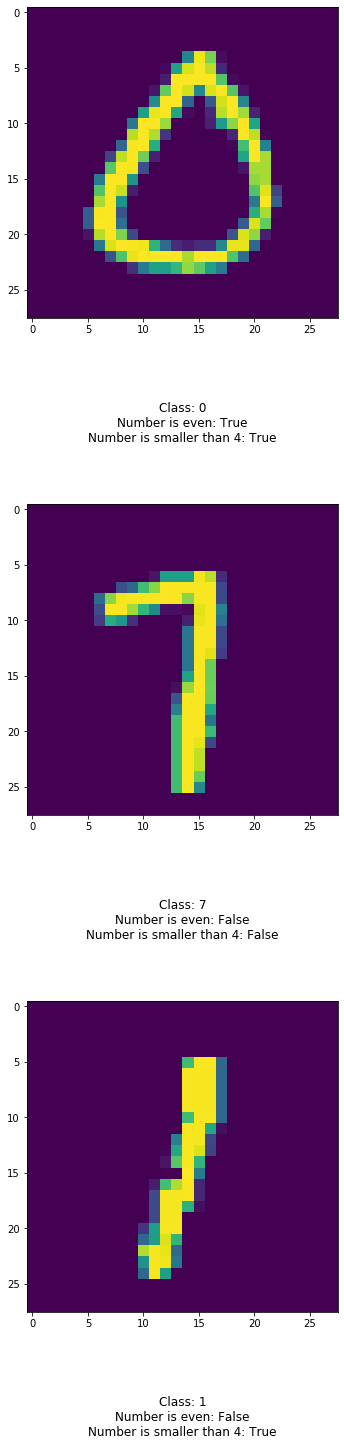

In [13]:
model.sample_eval(mnist_8, 3)

## 2) Dimensionality reduction on the representations of the layers

Ok, so now let's try to use dimensionality reduction to analyze the content of the different layers.

In [14]:
from numpy.random import shuffle

spl_size = 75
spl_ids = np.arange(mnist_8.n_train)
shuffle(spl_ids)
spl_ids = spl_ids[:spl_size]

mnist_8.spl = {
    'x': mnist_8.train['x'][spl_ids],
    'y': mnist_8.train['y'][spl_ids]
}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

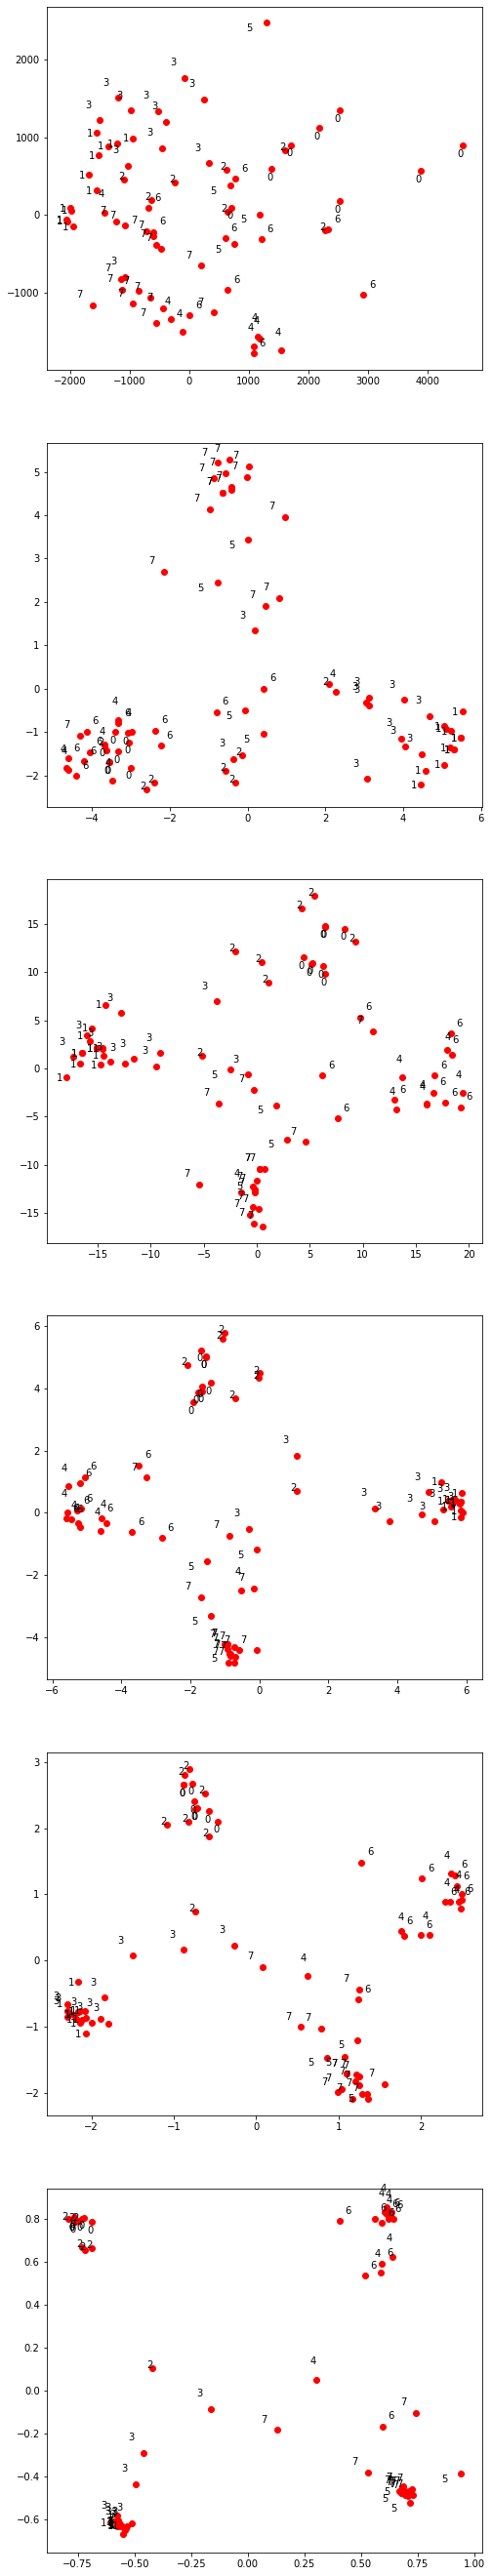

In [15]:
%matplotlib widget

from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
rprs1 = model.get_repr(mnist_8, mnist_8.spl, pca2)
fig1 = model.plot_reprs(mnist_8, mnist_8.spl, pca2)

In [16]:
for lay_id, rpr in enumerate(rprs1):
    print('Layer {0:d} - {1:.1f}% 2d var - {2:.1f}% + {3:.1f}%'.format(lay_id, 100*(rpr['reduced']['expl_var'][0]+rpr['reduced']['expl_var'][1]), 100*rpr['reduced']['expl_var'][0], 100*rpr['reduced']['expl_var'][1]))

Layer 0 - 53.9% 2d var - 37.4% + 16.6%
Layer 1 - 50.7% 2d var - 33.5% + 17.2%
Layer 2 - 76.0% 2d var - 47.9% + 28.1%
Layer 3 - 68.7% 2d var - 43.6% + 25.2%
Layer 4 - 96.6% 2d var - 53.3% + 43.4%
Layer 5 - 98.9% 2d var - 50.3% + 48.6%


In [17]:
%matplotlib widget
pca3 = PCA(n_components=3)
rprs2 = model.get_repr(mnist_8, mnist_8.spl, pca3)
fig2 = model.plot_reprs(mnist_8, mnist_8.spl, pca3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
for lay_id, rpr in enumerate(rprs2):
    print('Layer {0:d} - {1:.1f}% 3d var - {2:.1f}% + {3:.1f}% + {4:.1f}%'.format(lay_id, 100*(rpr['reduced']['expl_var'][0]+rpr['reduced']['expl_var'][1]+rpr['reduced']['expl_var'][2]), 100*rpr['reduced']['expl_var'][0], 100*rpr['reduced']['expl_var'][1], 100*rpr['reduced']['expl_var'][2]))

Layer 0 - 67.3% 3d var - 37.4% + 16.6% + 13.4%
Layer 1 - 61.4% 3d var - 33.5% + 17.2% + 10.6%
Layer 2 - 89.4% 3d var - 47.9% + 28.1% + 13.4%
Layer 3 - 85.6% 3d var - 43.6% + 25.2% + 16.9%
Layer 4 - 99.2% 3d var - 53.3% + 43.4% + 2.6%
Layer 5 - 99.8% 3d var - 50.3% + 48.6% + 0.9%


## 3) Analysis in terms of cross-condition generalization performance (CCGP) and parallelism score (PS)

## Paralellism Score (PS)

In [19]:
PScores = model.get_all_PS(mnist_8, rprs1, lay_id=5)

100%|██████████| 35/35 [00:00<00:00, 181.46it/s]


 49%|████▊     | 17/35 [00:00<00:00, 161.59it/s]

LAYER 0 - Representation parallelism score


 43%|████▎     | 15/35 [00:00<00:00, 145.97it/s]

Top dichotomies for PS
________________________
Dich: (0, 2, 4, 6) ranks 1 (PS=0.488036)
Dich: (0, 4, 5, 6) ranks 2 (PS=0.474241)
Dich: (0, 2, 5, 6) ranks 3 (PS=0.465045)
Dich: (0, 3, 5, 6) ranks 4 (PS=0.429548)
Dich: (0, 2, 3, 5) ranks 5 (PS=0.382044)
Dich: (0, 4, 5, 7) ranks 6 (PS=0.334876)
Dich: (0, 2, 4, 5) ranks 7 (PS=0.327802)
Dich: (0, 5, 6, 7) ranks 8 (PS=0.310025)
LAYER 1 - Representation parallelism score


100%|██████████| 35/35 [00:00<00:00, 212.22it/s]


Top dichotomies for PS
________________________
Dich: (0, 2, 4, 6) ranks 1 (PS=0.435934)
Dich: (0, 4, 6, 7) ranks 2 (PS=0.341273)
Dich: (0, 4, 5, 6) ranks 3 (PS=0.311487)
Dich: (0, 1, 2, 3) ranks 4 (PS=0.277618)
Dich: (0, 2, 5, 6) ranks 5 (PS=0.261458)
Dich: (0, 5, 6, 7) ranks 6 (PS=0.260032)
Dich: (0, 4, 5, 7) ranks 7 (PS=0.230989)
Dich: (0, 2, 6, 7) ranks 8 (PS=0.221775)
LAYER 2 - Representation parallelism score
Top dichotomies for PS
________________________
Dich: (0, 2, 4, 6) ranks 1 (PS=0.615232)
Dich: (0, 1, 2, 3) ranks 2 (PS=0.592848)
Dich: (0, 4, 5, 6) ranks 3 (PS=0.448526)
Dich: (0, 2, 5, 6) ranks 4 (PS=0.436210)
Dich: (0, 4, 6, 7) ranks 5 (PS=0.431160)
Dich: (0, 2, 3, 6) ranks 6 (PS=0.372989)
Dich: (0, 5, 6, 7) ranks 7 (PS=0.368119)
Dich: (0, 3, 4, 6) ranks 8 (PS=0.368020)
LAYER 3 - Representation parallelism score


  0%|          | 0/35 [00:00<?, ?it/s]

Top dichotomies for PS
________________________
Dich: (0, 1, 2, 3) ranks 1 (PS=0.539792)
Dich: (0, 2, 4, 6) ranks 2 (PS=0.522560)
Dich: (0, 5, 6, 7) ranks 3 (PS=0.337135)
Dich: (0, 4, 6, 7) ranks 4 (PS=0.336161)
Dich: (0, 4, 5, 6) ranks 5 (PS=0.318637)
Dich: (0, 2, 5, 6) ranks 6 (PS=0.303994)
Dich: (0, 2, 3, 6) ranks 7 (PS=0.271186)
Dich: (0, 2, 6, 7) ranks 8 (PS=0.258216)
LAYER 4 - Representation parallelism score
Top dichotomies for PS
________________________
Dich: (0, 2, 4, 6) ranks 1 (PS=0.992010)
Dich: (0, 1, 2, 3) ranks 2 (PS=0.978191)
Dich: (0, 3, 4, 6) ranks 3 (PS=0.778840)
Dich: (0, 2, 5, 6) ranks 4 (PS=0.616410)
Dich: (0, 3, 5, 6) ranks 5 (PS=0.561726)
Dich: (0, 4, 5, 6) ranks 6 (PS=0.540185)
Dich: (0, 2, 3, 6) ranks 7 (PS=0.532068)
Dich: (0, 4, 6, 7) ranks 8 (PS=0.528452)
LAYER 5 - Representation parallelism score


100%|██████████| 35/35 [00:00<00:00, 233.35it/s]


Top dichotomies for PS
________________________
Dich: (0, 2, 4, 6) ranks 1 (PS=0.991534)
Dich: (0, 1, 2, 3) ranks 2 (PS=0.985097)
Dich: (0, 3, 4, 6) ranks 3 (PS=0.725754)
Dich: (0, 1, 2, 7) ranks 4 (PS=0.646801)
Dich: (0, 4, 5, 6) ranks 5 (PS=0.430103)
Dich: (0, 4, 6, 7) ranks 6 (PS=0.415147)
Dich: (0, 1, 2, 6) ranks 7 (PS=0.415017)
Dich: (0, 2, 3, 6) ranks 8 (PS=0.414675)


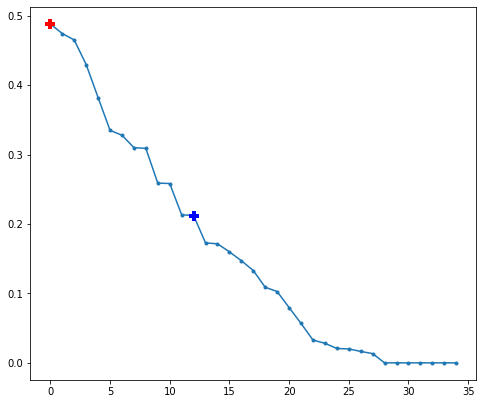

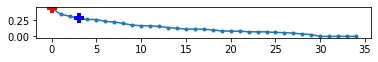

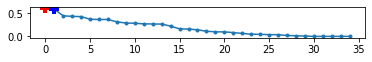

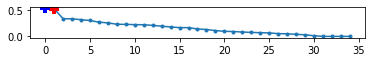

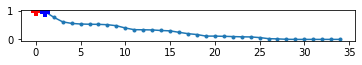

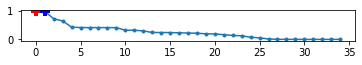

<Figure size 432x288 with 0 Axes>

In [40]:
# Creates subplots and unpacks the output array immediately

PScores = []
ps = []
ps_top_dichs = []

fig = plt.figure(figsize=(8, 8*model.n_layers))
axes = []
gs1 = gridspec.GridSpec(model.n_layers,1)
gs1.update(wspace=0.025, hspace=0.2)

for lay_id, _ in enumerate(model.layers):
    print("LAYER {0:d} - Representation parallelism score".format(lay_id))
    
    ax = plt.subplot(gs1[lay_id])
    PScores.append(model.get_all_PS(mnist_8, rprs1, lay_id=lay_id))
    
    ps.append([pscore for pscore in PScores[lay_id].values()])
    ps_top_dichs.append([dich for dich in PScores[lay_id].keys()])
    fig = plt.figure()
    ax.plot(range(len(ps[lay_id])), ps[lay_id], marker='.')
    
    parity_rank = ps_top_dichs[lay_id].index((0, 2, 4, 6))
    greatness_rank = ps_top_dichs[lay_id].index((0, 1, 2, 3))
    ax.plot(parity_rank, ps[lay_id][parity_rank], marker='+', color='red', markersize=10, markeredgewidth=4)
    ax.plot(greatness_rank, ps[lay_id][greatness_rank], marker='+', color='blue', markersize=10, markeredgewidth=4)
    
    print("Top dichotomies for PS\n________________________")
    for rk, dich in enumerate(ps_top_dichs[lay_id][:8]):
        print("Dich: {0:s} ranks {1:d} (PS={2:f})".format(str(dich), rk+1, ps[lay_id][rk]))

In [28]:
for rk, dich in enumerate(ps_top_dichs[:8]):
    print("Dich: {0:s} ranks {1:d} (PS={2:f})".format(str(dich), rk+1, ps[rk]))

Dich: (0, 2, 4, 6) ranks 1 (PS=0.991534)
Dich: (0, 1, 2, 3) ranks 2 (PS=0.985097)
Dich: (0, 3, 4, 6) ranks 3 (PS=0.725754)
Dich: (0, 1, 2, 7) ranks 4 (PS=0.646801)
Dich: (0, 4, 5, 6) ranks 5 (PS=0.430103)
Dich: (0, 4, 6, 7) ranks 6 (PS=0.415147)
Dich: (0, 1, 2, 6) ranks 7 (PS=0.415017)
Dich: (0, 2, 3, 6) ranks 8 (PS=0.414675)


## Cross-Condition Generalization Performance (CCGP)

In [30]:
(w_in, w_1, w_2, w_out) = (mnist_8.tot_dim, 100, 100, 4)
max_epochs = 400
max_epochs = 400
dnn_hstack_classif = Sequential([
    Dense(w_1, input_shape=(w_in,)),
    Activation('tanh'),
    Dense(w_2),
    Activation('tanh'),
    Dense(w_out),
    Activation('softmax')
])

ccgp_model = Model(dnn_hstack_classif)

In [ ]:
import pdb
import types
from sklearn.svm import SVC, LinearSVC

def _patch_get_dich_CCGP(self, ds, dich, n_labels_retained=2):
		"""
		CCGP is defined as the capacity to generalize on an unseen condition from training on a subset of possible conditions
		"""
		dich_0 = dich
		dich_1 = np.setdiff1d(ds.labels, dich_0)
		assert len(dich_0) == len(dich_1)

		# For now, labels will only be retained from dich_1 and will be random within dich_1
		retained_labels = np.random.choice(dich_1, size=n_labels_retained, replace=False)
		train_labels = np.setdiff1d(ds.labels, retained_labels)

		ds_gnr = ds.generate_gnr_set(train_labels)
		#ds_gnr.spl = ds.spl

		dich_name = ''.join([str(x) for x in dich_0])
		ds_gnr.build_dichLabels([dich_0, dich_1], dich_name)
		ds_gnr.train['dichs'][dich_name] = ds_gnr.train['dichs'][dich_name][:,0]
		ds_gnr.test['dichs'][dich_name] = ds_gnr.test['dichs'][dich_name][:,0]
		ds_gnr.gnr['dichs'][dich_name] = ds_gnr.gnr['dichs'][dich_name][:,0]
		
		# Create the linear classifier and train it on the submodel instance
		svc = LinearSVC()
		rpr = {
			'train': self.get_repr(ds_gnr, ds_gnr.train, dimRed=None),
			'test': self.get_repr(ds_gnr, ds_gnr.test, dimRed=None),
			'gnr': self.get_repr(ds_gnr, ds_gnr.gnr, dimRed=None)
		}

		CCGP_across_layers = []

		for lay_id in range(self.n_layers):
			#pca2 = PCA(n_components=2)
			#train_red_repr = pca2.fit_transform(rpr['train'][lay_id]['original']['repr'])
            #svc.fit(train_red_repr, ds_gnr.train['dichs'][dich_name])
			svc.fit(rpr['train'][lay_id]['original']['repr'], ds_gnr.train['dichs'][dich_name])

			train_score = svc.score(rpr['train'][lay_id]['original']['repr'], ds_gnr.train['dichs'][dich_name])
			test_score = svc.score(rpr['test'][lay_id]['original']['repr'], ds_gnr.test['dichs'][dich_name])
			gnr_score = svc.score(rpr['gnr'][lay_id]['original']['repr'], ds_gnr.gnr['dichs'][dich_name])

			# Evaluate performance
			CCGP_across_layers.append({
				'train_labels': train_labels,
				'retained_labels': retained_labels,
				'train_score': train_score,
				'test_score': test_score,
				'gnr_score': gnr_score
			})

		return CCGP_across_layers
    
ccgp_model.get_dich_CCGP  = types.MethodType(_patch_get_dich_CCGP, ccgp_model)

In [ ]:
def _patch_generate_gnr_set(self, train_labels, normalize=True):
	gnr_labels = np.setdiff1d(self.labels, train_labels)
	in_filt_train = np.isin(self.train['y'], train_labels)
	x_filt_train = np.where(in_filt_train)[0]
	x_train = self.train['x'].take(x_filt_train, axis=0)
	if normalize:
		x_train = normalize_array(x_train)

	dim_list = [d for d in self.axes_dim]
	dtuple_train = dim_list.copy()
	dtuple_train.insert(0, x_train.shape[0])
	dtuple_train = tuple(dtuple_train)
	x_train = x_train.reshape(dtuple_train)
	y_train = self.train['y'][in_filt_train]
	
	in_filt_test = np.isin(self.test['y'], train_labels)
	x_filt_test = np.where(in_filt_test)[0]
	x_test = self.test['x'].take(x_filt_test, axis=0)
	if normalize:
		x_test = normalize_array(x_test)

	dtuple_test = dim_list.copy()
	dtuple_test.insert(0, x_test.shape[0])
	dtuple_test = tuple(dtuple_test)
	x_test = x_test.reshape(dtuple_test)
	y_test = self.test['y'][in_filt_test]
	
	x_filt_gnrtrain = np.where(~in_filt_train)[0]
	x_filt_gnrtest = np.where(~in_filt_test)[0]
	x_gnr = self.train['x'].take(x_filt_gnrtrain, axis=0)
	x_gnr = np.vstack((x_gnr, self.test['x'].take(x_filt_gnrtest, axis=0)))
	if normalize:
		x_gnr = normalize_array(x_gnr)
		
	dtuple_gnr = dim_list.copy()
	dtuple_gnr.insert(0, x_gnr.shape[0])
	dtuple_gnr = tuple(dtuple_gnr)
	x_gnr = x_gnr.reshape(dtuple_gnr)
	y_gnr = self.train['y'][~in_filt_train]
	y_gnr = np.hstack((y_gnr, self.test['y'][~in_filt_test]))
	
	return ImageDataset(x_train, y_train, x_test, y_test, x_gnr, y_gnr)

mnist_8.generate_gnr_set = types.MethodType(_patch_generate_gnr_set, mnist_8)

def normalize_array(ar):
	"""
	Each row must be an entry, each column must be a dimension
	"""
	ar_mean = np.mean(ar, axis=0)
	nar = ar - ar_mean
	ar_min = np.min(nar, axis=0)
	ar_max = np.max(nar, axis=0)
	nar = np.divide(2*nar, ar_max-ar_min, out=np.zeros_like(nar), where=(ar_max!=ar_min)) - np.divide(ar_max+ar_min, ar_max-ar_min, out=np.zeros_like(nar), where=(ar_max!=ar_min))
	return nar

In [31]:
start = time()
CCGP1_across_layers = ccgp_model.get_dich_CCGP(mnist_8, (0, 2, 4, 6), n_labels_retained=1)
dur1 = time() - start
print("CCGP_1 computation on parity dichotomy took {0:.1f}s".format(dur1))

/home/proprietaire/Envs/GeomAbs/geom_abs/methods/models.py:129: RuntimeWarning: Mean of empty slice
  rprs[lay_id]['original']['avg_lbl_repr'][lbl_id] = np.nanmean(np.array(rprs[lay_id]['original']['repr'])[filt,:], axis=0)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CCGP_1 computation on parity dichotomy took 24.9s


In [32]:
start_2 = time()
CCGP2_across_layers = ccgp_model.get_dich_CCGP(mnist_8, (0, 2, 4, 6), n_labels_retained=2)
dur_2 = time() - start_2
print("CCGP_2 computation on parity dichotomy took {0:.1f}s".format(dur_2))

/home/proprietaire/Envs/GeomAbs/geom_abs/methods/models.py:129: RuntimeWarning: Mean of empty slice
  rprs[lay_id]['original']['avg_lbl_repr'][lbl_id] = np.nanmean(np.array(rprs[lay_id]['original']['repr'])[filt,:], axis=0)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CCGP_2 computation on parity dichotomy took 24.6s


In [33]:
dichs_to_include = [tuple(mnist8_parity[0]), tuple(mnist8_smallness[0])]
perfs = ccgp_model.get_all_CCGP(mnist_8, max_n_dichs=20, dichs_to_include=dichs_to_include)

  0%|          | 0/21 [00:00<?, ?it/s]/home/proprietaire/Envs/GeomAbs/geom_abs/methods/models.py:129: RuntimeWarning: Mean of empty slice
  rprs[lay_id]['original']['avg_lbl_repr'][lbl_id] = np.nanmean(np.array(rprs[lay_id]['original']['repr'])[filt,:], axis=0)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/proprietaire/Envs/GeomAbs/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
  5%|▍         | 1/21 [00:28<09:32, 28.63s/it]/home/proprietaire/Envs/Ge

LAYER 0 - Representation CCGP score
Top dichotomies for CCGP
________________________
Dich: (0, 5, 6, 7) ranks 1 (CCGP=0.835488)
Dich: (2, 4, 5, 6) ranks 2 (CCGP=0.817801)
Dich: (1, 2, 4, 7) ranks 3 (CCGP=0.692701)
Dich: (0, 2, 4, 6) ranks 4 (CCGP=0.554843)
Dich: (1, 2, 5, 6) ranks 5 (CCGP=0.539953)
Dich: (0, 2, 5, 7) ranks 6 (CCGP=0.494573)
Dich: (0, 1, 2, 5) ranks 7 (CCGP=0.467737)
Dich: (0, 1, 2, 6) ranks 8 (CCGP=0.439510)
LAYER 1 - Representation CCGP score
Top dichotomies for CCGP
________________________
Dich: (1, 2, 4, 7) ranks 1 (CCGP=0.766788)
Dich: (2, 4, 5, 6) ranks 2 (CCGP=0.737504)
Dich: (0, 2, 4, 6) ranks 3 (CCGP=0.645629)
Dich: (0, 5, 6, 7) ranks 4 (CCGP=0.638332)
Dich: (0, 2, 3, 7) ranks 5 (CCGP=0.625320)
Dich: (0, 1, 3, 5) ranks 6 (CCGP=0.578386)
Dich: (0, 1, 2, 5) ranks 7 (CCGP=0.412571)
Dich: (0, 2, 5, 7) ranks 8 (CCGP=0.396201)
LAYER 2 - Representation CCGP score
Top dichotomies for CCGP
________________________
Dich: (1, 2, 4, 7) ranks 1 (CCGP=0.787956)
Dich: (0, 5

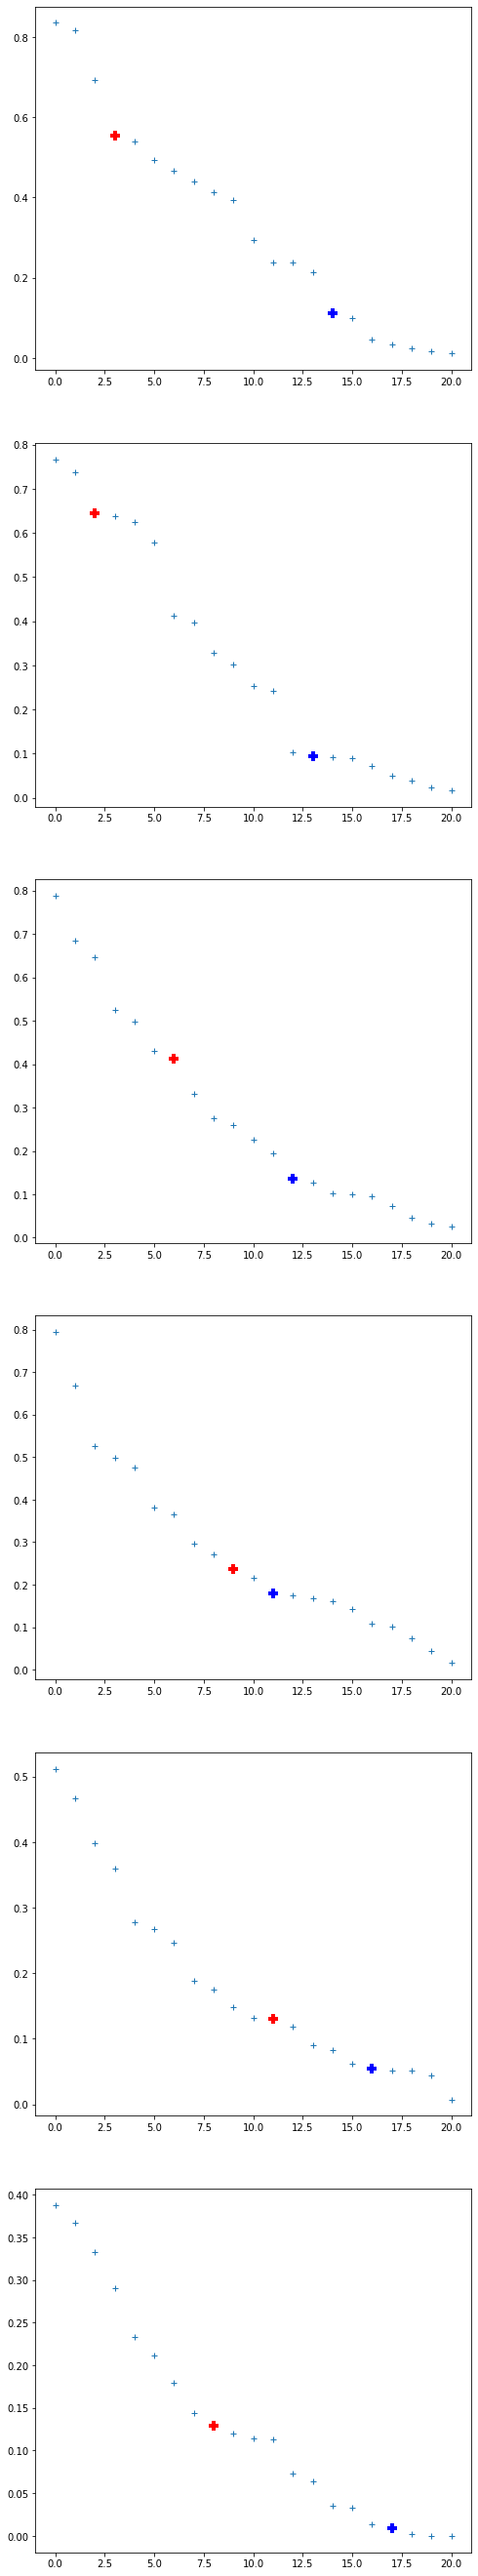

In [35]:
ccgp_scores = []
df_perf = []
ccgp_top_dichs = []

fig = plt.figure(figsize=(8, 8*ccgp_model.n_layers))
axes = []
gs1 = gridspec.GridSpec(ccgp_model.n_layers,1)
gs1.update(wspace=0.025, hspace=0.2)

for lay_id, _ in enumerate(ccgp_model.layers):
    print("LAYER {0:d} - Representation CCGP score".format(lay_id))
    
    ax = plt.subplot(gs1[lay_id])
    ccgp_scores.append({k: v[lay_id] for k,v in perfs.items()})
    df_perf.append(pd.DataFrame.from_dict(ccgp_scores[lay_id], orient='index'))
    ccgp = [score for score in df_perf[lay_id]['gnr_score']]
    sort_ids = np.argsort(ccgp).tolist()
    sort_ids.reverse()
    ccgp = [ccgp[i] for i in sort_ids]
    ccgp_top_dichs.append(df_perf[lay_id].index)
    ccgp_top_dichs[lay_id] = [ccgp_top_dichs[lay_id][i] for i in sort_ids]
    ax.plot(ccgp, linestyle='', marker='+')
    
    parity_rank = ccgp_top_dichs[lay_id].index((0, 2, 4, 6))
    greatness_rank = ccgp_top_dichs[lay_id].index((0, 1, 2, 3))
    ax.plot(parity_rank, ccgp[parity_rank], marker='+', color='red', markersize=10, markeredgewidth=4)
    ax.plot(greatness_rank, ccgp[greatness_rank], marker='+', color='blue', markersize=10, markeredgewidth=4)
    
    print("Top dichotomies for CCGP\n________________________")
    for rk, dich in enumerate(ccgp_top_dichs[lay_id][:8]):
        print("Dich: {0:s} ranks {1:d} (CCGP={2:f})".format(str(dich), rk+1, ccgp[rk]))